<a href="https://colab.research.google.com/github/ElPayo684/ITESM_PI/blob/main/Unfisheye_%2B_Puntos_%2B_rectificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
from IPython.display import display, HTML, Javascript
import json
import base64
from io import BytesIO
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def show(img, title=None):
    if img.ndim == 3:
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        rgb = img

    h, w = rgb.shape[:2]
    dpi = 100
    figsize = (w / dpi, h / dpi)

    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(rgb, cmap=None if rgb.ndim == 3 else "gray")
    if title:
        plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def corregir_fisheye_completo(img, fuerza=0.2, zoom=0.6):
    """
    Corrige fisheye manteniendo toda la imagen visible

    fuerza: 0.1-0.5 (qué tanto corregir)
    zoom: 0.4-1.0 (qué tanto hacer zoom out para ver todo)
          Valores más bajos = más imagen visible pero más pequeña en el centro
    """
    h, w = img.shape[:2]

    # Matriz de cámara con zoom ajustado
    focal = w * zoom  # Reducir focal para ver más contenido
    K = np.array([[focal, 0, w / 2],
                  [0, focal, h / 2],
                  [0, 0, 1]], dtype=np.float32)

    # Coeficientes de distorsión
    D = np.array([-fuerza, fuerza/3, 0.0, 0.0], dtype=np.float32)

    # Nueva matriz de cámara para el output (con más FOV)
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(
        K, D, (w, h), np.eye(3), balance=1.0  # balance=1.0 mantiene todo visible
    )

    # Mapas de corrección
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(
        K, D, np.eye(3), new_K, (w, h), cv2.CV_16SC2
    )

    # Aplicar corrección
    img_corregida = cv2.remap(img, map1, map2,
                              interpolation=cv2.INTER_LINEAR,
                              borderMode=cv2.BORDER_CONSTANT)

    return img_corregida

In [ ]:

# ----------------------------
# Cargar imagen
# ----------------------------
path = '/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/rawdata/20251022075804.jpg'
img = cv2.imread(path)
h, w = img.shape[:2]
print(f"Dimensiones originales: {w} x {h}")

# ----------------------------
# Corrección con imagen completa
# ----------------------------
img_unfisheye = corregir_fisheye_completo(img, fuerza=0.1, zoom=0.6)

# Mostrar comparación
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original (con Fisheye)", fontsize=16, weight='bold')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(img_unfisheye, cv2.COLOR_BGR2RGB))
axes[1].set_title("Corregida (imagen completa visible)", fontsize=16, weight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✅ Dimensiones finales: {img_unfisheye.shape[1]} x {img_unfisheye.shape[0]}")

# Guardar
cv2.imwrite('imagen_sin_fisheye_completa.jpg', img_unfisheye)
print("💾 Guardada como: imagen_sin_fisheye_completa.jpg")

NameError: name 'cv2' is not defined


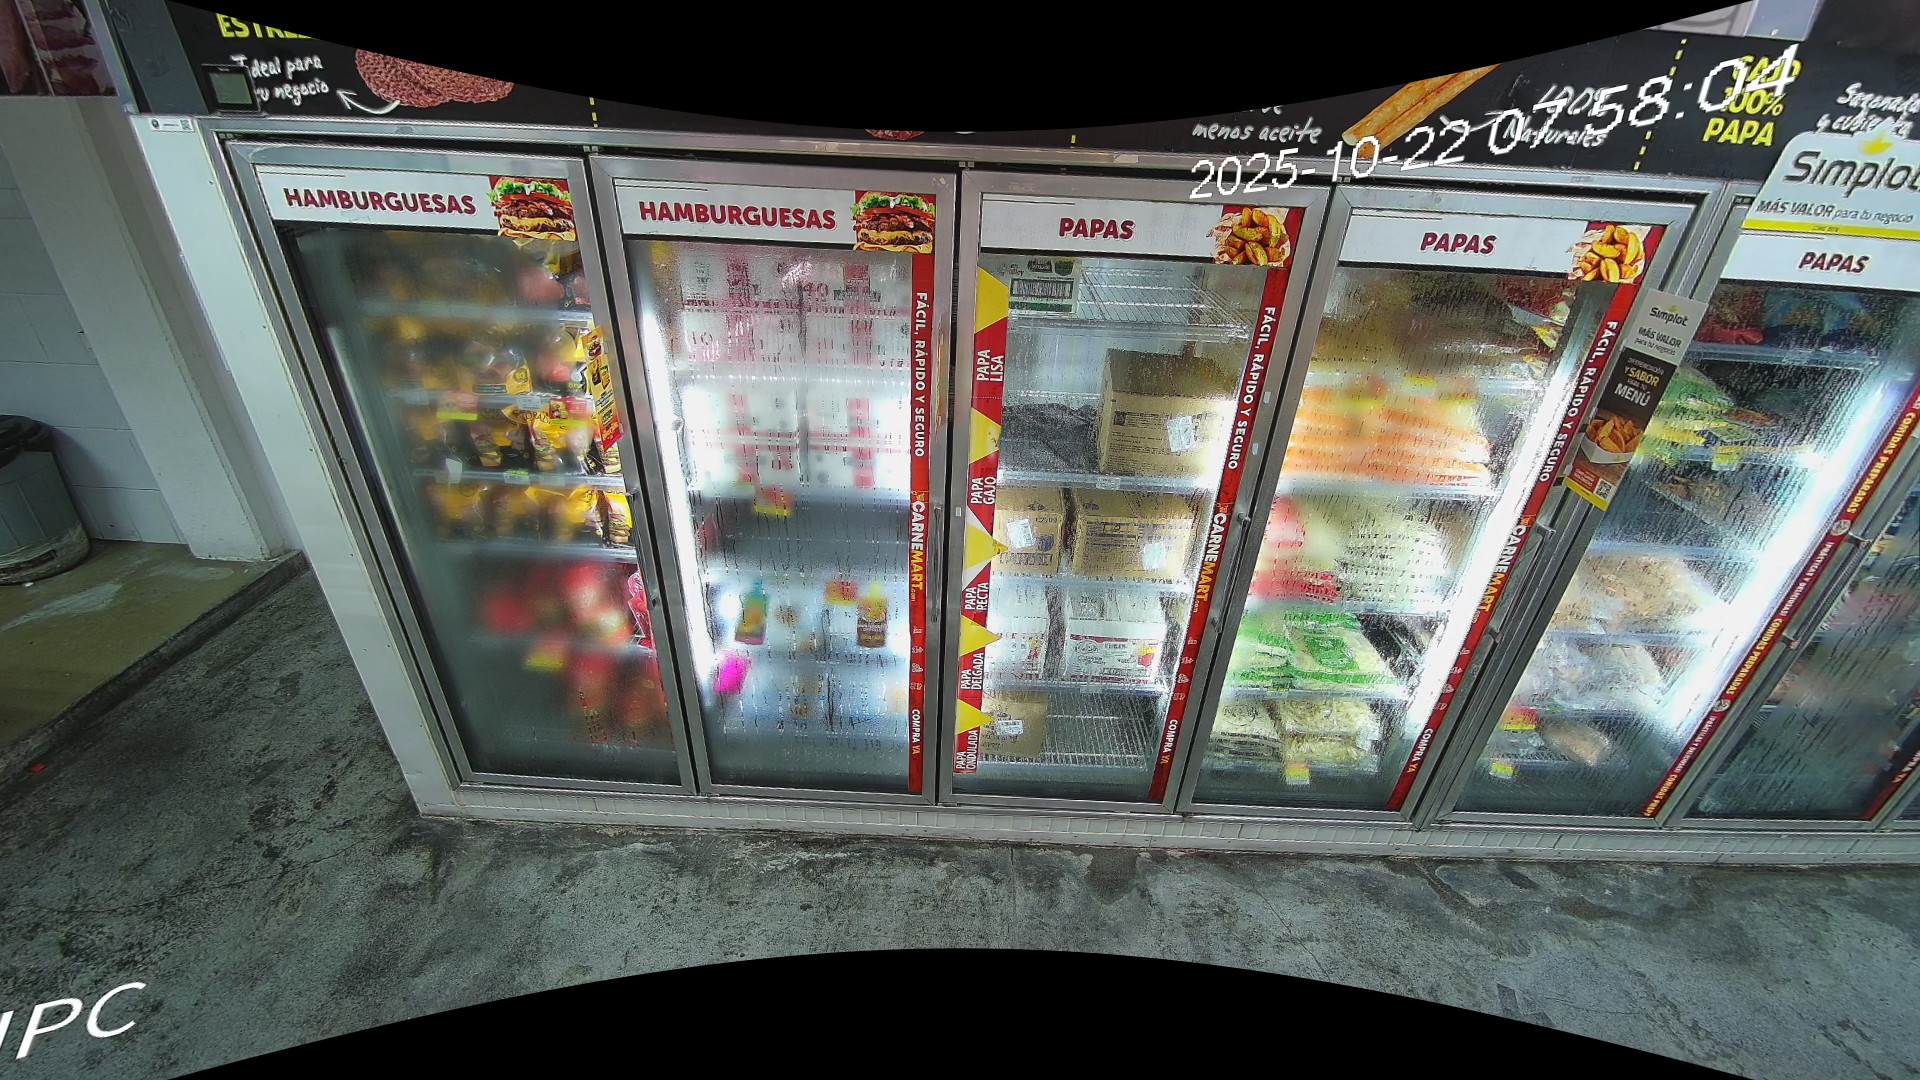


✅ Interfaz cargada. Haz clic en la imagen para seleccionar puntos.


In [ ]:
img_cv = img_unfisheye
original = img_cv.copy()
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# Convertir a base64 para HTML
pil_img = Image.fromarray(img_rgb)
buffered = BytesIO()
pil_img.save(buffered, format="PNG")
img_base64 = base64.b64encode(buffered.getvalue()).decode()

# HTML con JavaScript para clicks
html_code = f"""
<div id="container" style="text-align: center;">
    <h2>🖱️ Haz clic en 4 esquinas del objeto</h2>
    <p id="status" style="font-size: 18px; font-weight: bold;">Puntos seleccionados: 0/4</p>
    <div style="position: relative; display: inline-block;">
        <canvas id="canvas" width="{img_rgb.shape[1]}" height="{img_rgb.shape[0]}"
                style="border: 3px solid #333; cursor: crosshair;"></canvas>
    </div>
    <br><br>
    <button onclick="resetPoints()" style="padding: 10px 20px; font-size: 16px; background: #ff6b6b; color: white; border: none; border-radius: 5px; cursor: pointer;">
        🔄 Resetear Puntos
    </button>
</div>

<script>
const canvas = document.getElementById('canvas');
const ctx = canvas.getContext('2d');
const img = new Image();
img.src = 'data:image/png;base64,{img_base64}';

let points = [];

img.onload = function() {{
    ctx.drawImage(img, 0, 0);
}};

canvas.addEventListener('click', function(e) {{
    if (points.length >= 4) {{
        alert('Ya tienes 4 puntos. Ejecuta la siguiente celda o resetea.');
        return;
    }}

    const rect = canvas.getBoundingClientRect();
    const x = Math.round(e.clientX - rect.left);
    const y = Math.round(e.clientY - rect.top);

    points.push([x, y]);

    // Redibujar imagen
    ctx.drawImage(img, 0, 0);

    // Dibujar todos los puntos
    points.forEach((p, i) => {{
        // Círculo verde
        ctx.beginPath();
        ctx.arc(p[0], p[1], 12, 0, 2 * Math.PI);
        ctx.fillStyle = 'lime';
        ctx.fill();
        ctx.strokeStyle = 'white';
        ctx.lineWidth = 3;
        ctx.stroke();

        // Número
        ctx.font = 'bold 24px Arial';
        ctx.fillStyle = 'red';
        ctx.strokeStyle = 'white';
        ctx.lineWidth = 4;
        ctx.strokeText(String(i+1), p[0] + 20, p[1] - 20);
        ctx.fillText(String(i+1), p[0] + 20, p[1] - 20);
    }});

    // Actualizar status
    document.getElementById('status').textContent = `Puntos seleccionados: ${{points.length}}/4`;

    // Guardar en Python
    google.colab.kernel.invokeFunction('notebook.get_points', [points], {{}});

    if (points.length === 4) {{
        document.getElementById('status').innerHTML = '✅ 4 puntos seleccionados! <span style="color: green;">Ejecuta la siguiente celda</span>';
    }}
}});

function resetPoints() {{
    points = [];
    ctx.drawImage(img, 0, 0);
    document.getElementById('status').textContent = 'Puntos seleccionados: 0/4';
    google.colab.kernel.invokeFunction('notebook.get_points', [[]], {{}});
}}
</script>
"""

# Variable para almacenar puntos
puntos = []

def get_points(pts):
    global puntos
    puntos = pts
    return

# Registrar función
output.register_callback('notebook.get_points', get_points)

display(HTML(html_code))

print("\n✅ Interfaz cargada. Haz clic en la imagen para seleccionar puntos.")

🔄 Procesando imagen...



/tmp/ipython-input-1309306154.py:52: UserWarning:

Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-1309306154.py:52: UserWarning:

Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.



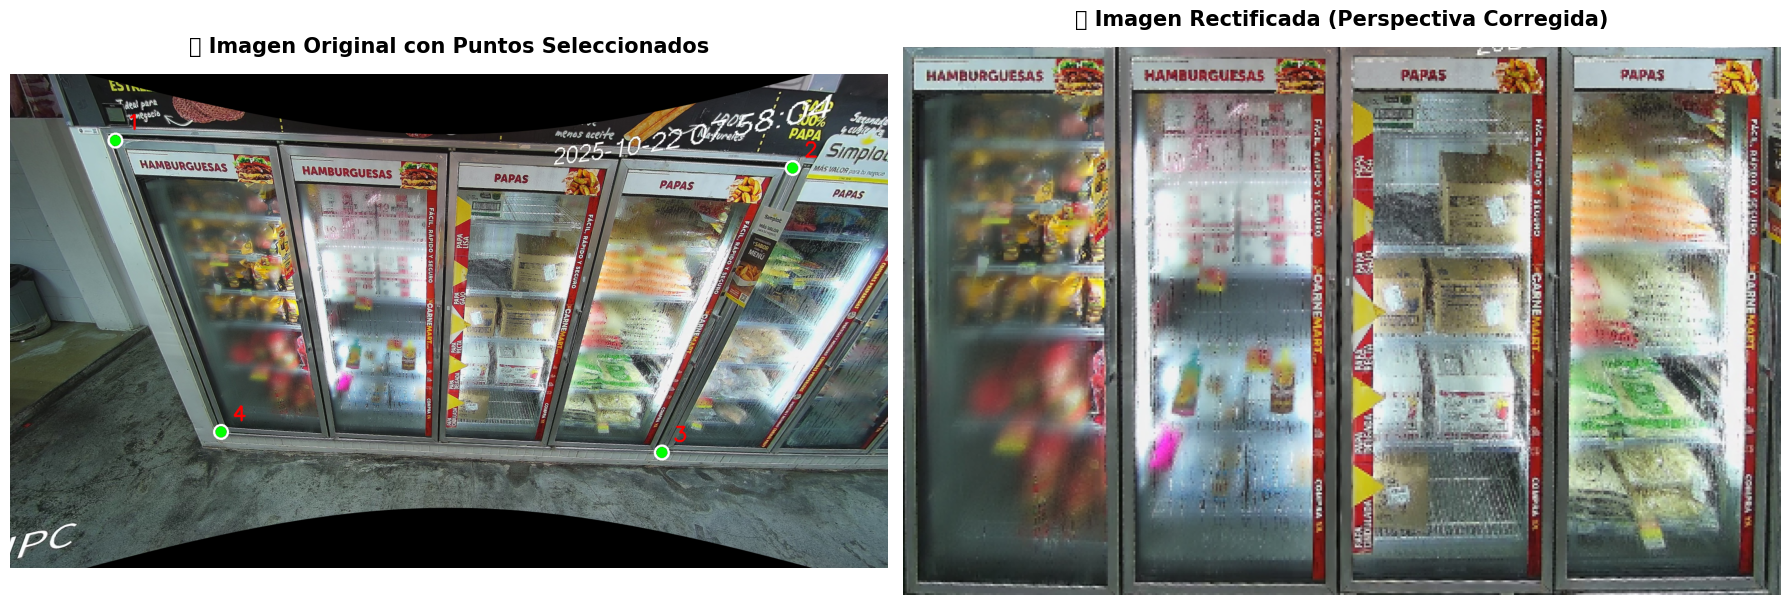

✅ ¡Rectificación completada exitosamente!

📍 Coordenadas de los puntos (ordenados automáticamente):
------------------------------------------------------------
   1. Arriba-Izquierda   : x= 230, y= 145
   2. Arriba-Derecha    : x=1711, y= 205
   3. Abajo-Derecha     : x=1425, y= 827
   4. Abajo-Izquierda   : x= 461, y= 782
------------------------------------------------------------
📐 Dimensiones de salida: 480 × 300 píxeles

💡 Tip: Puedes cambiar W y H en el código para ajustar el tamaño de salida

💾 ¿Quieres descargar la imagen rectificada?


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Imagen descargada: imagen_rectificada.png


In [ ]:
# ----------------------------
# Procesamiento y resultado
# ----------------------------
import matplotlib.pyplot as plt

def ordenar_puntos(pts):
    pts = np.array(pts, dtype=np.float32)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    rect = np.zeros((4, 2), dtype=np.float32)
    rect[0] = pts[np.argmin(s)]      # top-left
    rect[2] = pts[np.argmax(s)]      # bottom-right
    rect[1] = pts[np.argmin(diff)]   # top-right
    rect[3] = pts[np.argmax(diff)]   # bottom-left
    return rect

if len(puntos) != 4:
    print(f"❌ ERROR: Tienes {len(puntos)} puntos, necesitas exactamente 4")
    print("👆 Vuelve a la celda anterior y selecciona 4 puntos haciendo clic en la imagen")
else:
    print("🔄 Procesando imagen...\n")

    # Homografía
    pts1 = ordenar_puntos(puntos)
    W, H = 480, 300
    pts2 = np.float32([[0, 0], [W, 0], [W, H], [0, H]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    rectificada = cv2.warpPerspective(original, M, (W, H))

    # Imagen con puntos marcados
    img_con_puntos = original.copy()
    for i, pt in enumerate(pts1):
        x, y = int(pt[0]), int(pt[1])
        cv2.circle(img_con_puntos, (x, y), 12, (0, 255, 0), -1)
        cv2.circle(img_con_puntos, (x, y), 15, (255, 255, 255), 3)
        cv2.putText(img_con_puntos, str(i+1), (x+25, y-25),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 4)

    # Mostrar resultados lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    axes[0].imshow(cv2.cvtColor(img_con_puntos, cv2.COLOR_BGR2RGB))
    axes[0].set_title("📷 Imagen Original con Puntos Seleccionados",
                     fontsize=15, weight='bold', pad=15)
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(rectificada, cv2.COLOR_BGR2RGB))
    axes[1].set_title("✨ Imagen Rectificada (Perspectiva Corregida)",
                     fontsize=15, weight='bold', pad=15)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    print("✅ ¡Rectificación completada exitosamente!\n")
    print("📍 Coordenadas de los puntos (ordenados automáticamente):")
    print("-" * 60)
    nombres = ['Arriba-Izquierda  ', 'Arriba-Derecha   ',
               'Abajo-Derecha    ', 'Abajo-Izquierda  ']
    for i, pt in enumerate(pts1):
        print(f"   {i+1}. {nombres[i]} : x={int(pt[0]):4d}, y={int(pt[1]):4d}")
    print("-" * 60)
    print(f"📐 Dimensiones de salida: {W} × {H} píxeles")
    print("\n💡 Tip: Puedes cambiar W y H en el código para ajustar el tamaño de salida")

    # Opcional: Guardar la imagen rectificada
    print("\n💾 ¿Quieres descargar la imagen rectificada?")
    cv2.imwrite('imagen_rectificada.png', rectificada)
    files.download('imagen_rectificada.png')
    print("✅ Imagen descargada: imagen_rectificada.png")